In [49]:
#testing!
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
file1_path = 'educ_data.csv'
file2_path = 'gini_data.csv'
file3_path = 'unemp_data.csv'

educ_df = pd.read_csv(file1_path)
gini_df = pd.read_csv(file2_path)
unemp_df = pd.read_csv(file3_path)

In [50]:
# Clean unemp_df
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']  
year_columns = unemp_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
unemp_df = pd.melt(unemp_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Unemp %')

# Drop rows with no data
unemp_df = unemp_df.dropna(subset=['Unemp %'])

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
unemp_df['Year'] = unemp_df['Year'].str.extract('(\d+)').astype(int)

# Clean educ_df
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']  
year_columns = educ_df.columns[4:]  # All the year columns, starting from the 5th column onward

# Melt the dataframe to bring year columns into rows
educ_df = pd.melt(educ_df, id_vars=id_vars, value_vars=year_columns, var_name='Year', value_name='Average years of schooling')

# Drop rows with no data
educ_df = educ_df[educ_df['Average years of schooling'] != '..']

# Convert 'Year' to a numerical type if needed (strip out the text around it, like 'YR1960' to just '1960')
educ_df['Year'] = educ_df['Year'].str.extract('(\d+)').astype(int)

# Clean gini_df

gini_df["iso"] = gini_df["iso"].transform(lambda x: x.upper())
gini_df['gini_recalculated'] = pd.to_numeric(gini_df['gini_recalculated'], errors='coerce')
gini_df = gini_df.dropna(subset=['gini_recalculated'])

In [51]:
merged_df = pd.merge(gini_df,unemp_df,left_on=["iso","year"],right_on=["Country Code","Year"])
merged_df = pd.merge(merged_df,educ_df,left_on=["iso","year"],right_on=["Country Code","Year"])

columns_req = ['country', 'iso', 'year', 'gini_reported',
       'gdp_ppp_pc_usd2011', 'population',
       'gini_recalculated','Unemp %',
       'Series Name','Average years of schooling']

merged_df = merged_df[columns_req]
merged_df = merged_df[merged_df['Series Name'].str.contains('both sexes', case=False)]

# Step 2: Drop duplicate rows
merged_df = merged_df.drop_duplicates().reset_index(drop=True)
merged_df = merged_df.set_index(["country","year"])


In [52]:
print(merged_df)

                   iso gini_reported  gdp_ppp_pc_usd2011    population  \
country      year                                                        
Angola       2014  AGO     0.4445348         6283.000000  2.254955e+07   
Albania      2001  ALB   0.329893478         5845.833333  3.121602e+06   
             2008  ALB   0.319450431         8986.000000  3.002683e+06   
             2011  ALB   0.312414251         9987.250000  2.936239e+06   
             2012  ALB   0.310068857        10321.000000  2.914091e+06   
...                ...           ...                 ...           ...   
South Africa 2015  ZAF     0.6496464        12367.000000  5.529122e+07   
Zimbabwe     1992  ZWE        0.6392         2836.600000  1.063801e+07   
             2002  ZWE     0.6164938         2401.438000  1.266185e+07   
             2012  ZWE     0.4499857         1943.000000  1.438665e+07   
             2014  ZWE     0.4499857         1943.000000  1.438665e+07   

                   gini_recalculated 

## 2. Using the ARIMA model for forecasting inequality
ARIMA is a model used for time series forecasting, and we can use this to forecast inequality in various countries.

In order to find the best model for forecasting, we need to determine the parameters of the ARIMA model, namely:

**p: the number of autoregressive terms**

**d: the number of nonseasonal differences needed for stationarity**

**q: the number of lagged forecast errors in the prediction equation.**

### 2.1. Determining parameter d, the number of nonseasonal differences for stationarity

To use an ARIMA model, we need to ensure that the data is stationary by determining and eliminating seasonality by selecting an appropriate parameter d.

The parameter d is the "degree of differencing", which refers to the number of times a series is differenced. For example, if the series value is X_t, then 1 degree of differencing means the new value X_t' = X_t - X_t-1

We use both Autocorrelation Function (ACF) graphs and Augmented Dicky-Fuller tests to determine the number of differences needed (value of d).

#### 2.1.1 ACF graphs allow us to visualise the autocorrelation and hence seasonality

We will start by doing the analysis on Singapore, before conducting it across all countries.

In [53]:
# Clean gini_df
gini_columns_req = ['country', 'iso', 'year', 'gini_recalculated']

gini_df_clean = gini_df[gini_columns_req]
gini_df_clean = gini_df_clean.drop_duplicates().reset_index(drop=True)
gini_df_clean = gini_df_clean.set_index('year')

# Create singapore_df
singapore_df = gini_df_clean.loc[gini_df_clean['country']=='Singapore'].copy()
singapore_df.head()

,country,iso,gini_recalculated
year,,,
1967,Singapore,SGP,0.399908
1968,Singapore,SGP,0.399908
1969,Singapore,SGP,0.399908
1970,Singapore,SGP,0.399908
1971,Singapore,SGP,0.399908


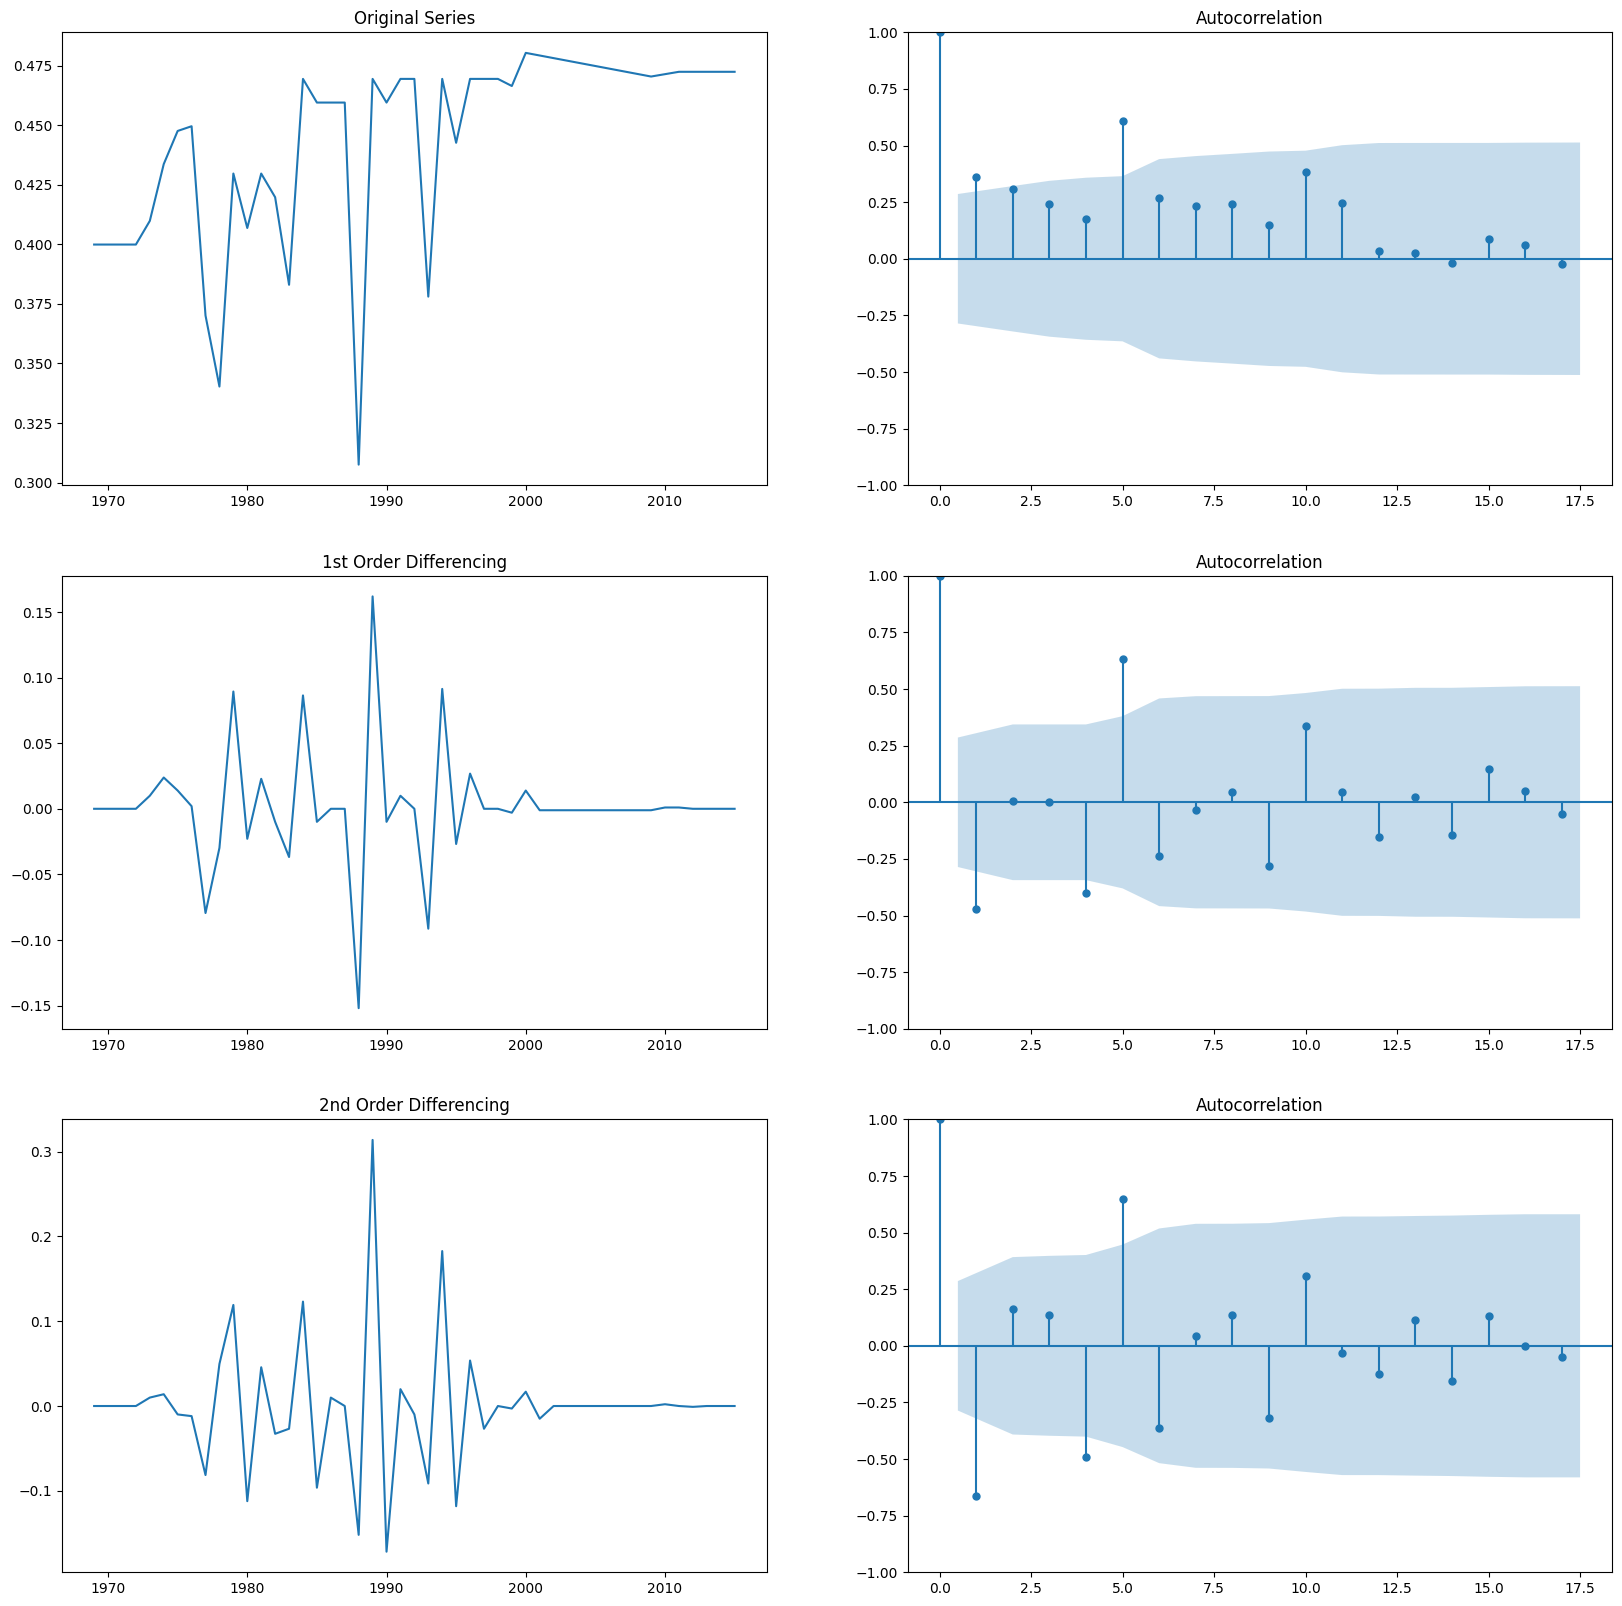

In [54]:
#Plotting ACF graphs

from statsmodels.graphics.tsaplots import plot_acf

# Create dataframes for d = 1 and d = 2 values of gini_recalculated
singapore_df['gini_recalculated_d1'] = singapore_df['gini_recalculated'].diff()
singapore_df['gini_recalculated_d2'] = singapore_df['gini_recalculated'].diff().diff()
singapore_df.dropna(inplace=True)

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(20,20))
axes[0, 0].plot(singapore_df['gini_recalculated'])
axes[0, 0].set_title('Original Series')
plot_acf(singapore_df['gini_recalculated'], ax=axes[0,1])

# 1st Differencing
axes[1, 0].plot(singapore_df['gini_recalculated_d1']); axes[1, 0].set_title('1st Order Differencing')
plot_acf(singapore_df['gini_recalculated_d1'], ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(singapore_df['gini_recalculated_d2']); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(singapore_df['gini_recalculated_d2'], ax=axes[2, 1])

plt.show()

The goal of differencing is to reduce autocorrelation trends to obtain stationarity. As seen from the ACF graphs above, d = 0  appears to have a gradual decline on autocorrelation, which is typical when the data is not stationary.

The ACF graph for d = 1 still shows some autocorrelation, but without any trend. Since d = 2 does not change much from d = 1, we will likely use d = 1 to prevent over-differencing.

#### 2.1.2. Augmented Dicky Fuller (ADF) Test
The ADF test is a numerical test for stationarity, to confirm our conclusions from the ACF graph.

In [55]:
#Calculating p-values for Augmented Dicky-Fuller (adfuller) Tests
from statsmodels.tsa.stattools import adfuller

gini_d0 = singapore_df['gini_recalculated'].tolist()
gini_d1 = singapore_df['gini_recalculated_d1'].tolist()
gini_d2 = singapore_df['gini_recalculated_d2'].tolist()

print('The p-value of adfuller test for d = 0 is:', adfuller(gini_d0)[1])
print('The p-value of adfuller test for d = 1 is:', adfuller(gini_d1)[1])
print('The p-value of adfuller test for d = 2 is:', adfuller(gini_d2)[1])


The p-value of adfuller test for d = 0 is: 0.6238813962601764
The p-value of adfuller test for d = 1 is: 1.0343995193247684e-16
The p-value of adfuller test for d = 2 is: 0.00028594779370281955


Since the p-value of the adfuller test is << 0.01 for d = 1, we will use d = 1 in our ARIMA model, which supports our initial hypothesis from the ACF graphs.

### 2.2. Determining the other ARIMA parameters (p and q)
In this section, we determine the number of autoregressive terms (p), and the number of lagged forecast errors  (q)

In [56]:
# Firstly, we split the data into train and test data: We are using 80% of data as training data
# We do not randomise the train & test data as we are comparing the forecast (from the train data) with the test data
# Hence, the test data will have to come chronologically after the train data
# The order of the data is important for time-series analysis

train=singapore_df[:int((80*len(singapore_df))/100)]["gini_recalculated"]
test=singapore_df[int((80*len(singapore_df))/100):]["gini_recalculated"]

print('Total data points:', len(singapore_df))
print('Training data points:',len(train))
print('Testing data points:',len(test))

Total data points: 47
Training data points: 37
Testing data points: 10


In [57]:
#Find all combinations of p, d and q through iteration

from statsmodels.tsa.arima.model import ARIMA
import itertools

p = range(0,10) # We selected the maximum value of p to be 10 to prevent overfitting
q = range(0,10) # We selected the maximum value of q to be 10 to prevent overfitting
d = range(1,2) # Determined earlier that d=1

pdq_combination=list(itertools.product(p,d,q))
pdq_combination # See all the iterations

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 1, 6),
 (1, 1, 7),
 (1, 1, 8),
 (1, 1, 9),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 1, 6),
 (2, 1, 7),
 (2, 1, 8),
 (2, 1, 9),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 1, 6),
 (3, 1, 7),
 (3, 1, 8),
 (3, 1, 9),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 1, 6),
 (4, 1, 7),
 (4, 1, 8),
 (4, 1, 9),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 1, 6),
 (5, 1, 7),
 (5, 1, 8),
 (5, 1, 9),
 (6, 1, 0),
 (6, 1, 1),
 (6, 1, 2),
 (6, 1, 3),
 (6, 1, 4),
 (6, 1, 5),
 (6, 1, 6),
 (6, 1, 7),
 (6, 1, 8),
 (6, 1, 9),
 (7, 1, 0),
 (7, 1, 1),
 (7, 1, 2),
 (7, 1, 3),
 (7, 1, 4),
 (7, 1, 5),
 (7, 1, 6),
 (7, 1, 7),
 (7, 1, 8),
 (7, 1, 9),
 (8, 1, 0),
 (8, 1, 1),
 (8, 1, 2),
 (8,

#### 2.2.1 Using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to determine the best ARIMA model

The AIC and BIC are ways to 'score' the ARIMA models - essentially, the ARIMA model with the lowest AIC/BIC (either one) will be the best model for forecasting.

In [58]:
import warnings
warnings.filterwarnings('ignore')

#Creating lists to store the values of AIC, BIC & respective (p,d,q) combinations
aic=[]
bic=[]
pdqCombs=[]


#This loop will try every combination of (p,d,q) in ARIMA models and calculate the AIC & BIC
for pdq in pdq_combination:
    model=ARIMA(train,order=pdq).fit()
    pred=model.predict(start=len(train),end=(len(singapore_df)-1))
    model_aic=model.aic
    model_bic=model.bic
    pdqCombs.append(pdq)
    aic.append(model_aic)
    bic.append(model_bic)


In [59]:
#Put the results into a dataframe

results = pd.DataFrame(index=pdqCombs, data=aic, columns=['AIC'])
results['BIC']=bic
results

,AIC,BIC
"(0, 1, 0)",-109.978176,-108.394657
"(0, 1, 1)",-126.405304,-123.238266
"(0, 1, 2)",-124.425889,-119.675332
"(0, 1, 3)",-124.027232,-117.693157
"(0, 1, 4)",-129.292278,-121.374683
...,...,...
"(9, 1, 5)",-119.352357,-95.599573
"(9, 1, 6)",-117.352259,-92.015956
"(9, 1, 7)",404.655219,431.575041
"(9, 1, 8)",-118.995439,-90.492098


In [60]:
# Since AIC < BIC, we will use the p,d,q values for the index with the lowest AIC
print(results[['AIC']].min())
print(results[['BIC']].min())

AIC   -134.541367
dtype: float64
BIC   -126.623772
dtype: float64


In [62]:
#To find the index - the p,d,q values - that give the lowest AIC values
establishedmodel=results['AIC'].idxmin()
establishedmodel

(4, 1, 0)

In [63]:
# Train the ARIMA model with the (p,d,q) obtained for the lowest AIC, (4,2,0)
model=ARIMA(train,order=establishedmodel).fit()

In [64]:
# Predict the values of the gini coefficient for the duration of the test data
pred=model.predict(start=len(train),end=(len(singapore_df)-1))
pred

37    0.477639
38    0.477533
39    0.477232
40    0.476618
41    0.475583
42    0.476961
43    0.477095
44    0.477131
45    0.476883
46    0.476116
Name: predicted_mean, dtype: float64

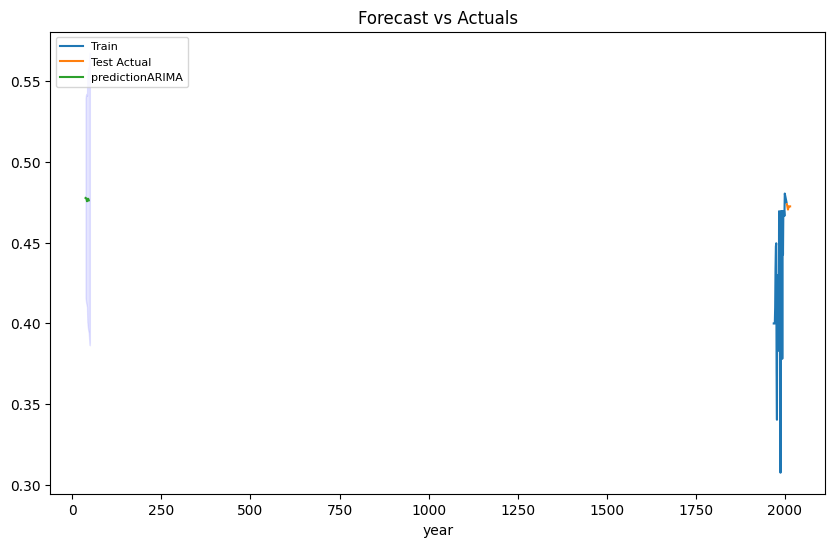

In [65]:
#Plot graphs
train.plot(legend=True, label='Train', figsize=(10,6)) # Plot train data
test.plot(legend=True, label='Test Actual') # Plot test data (Actual Death Counts)
pred.plot(legend=True, label='predictionARIMA') # Plot predicted values

#Calculate and plot confidence intervals
forecasts=model.get_forecast(13) #95% confidence interval
ci=forecasts.conf_int()
lower_series = pd.Series(ci.loc[:,'lower gini_recalculated'])
upper_series = pd.Series(ci.loc[:,'upper gini_recalculated'])

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='b', alpha=.1)

#Title and legend
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()